In [1]:
import numpy as np
import os
import tensorflow as tf
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.insert(0, '../')
from edgeml.emi_rnn import NetworkJoint
from edgeml.emi_rnn import getJointPredictions
from edgeml.emi_rnn import earlyPolicy_baseCase
from edgeml.emi_rnn import earlyPolicy_minProb
from edgeml.mi_rnn import NetworkV2
from edgeml.mi_rnn import updateYPolicy4
from edgeml.mi_rnn import getUpdateIndexList
from edgeml.mi_rnn import  analysisModelMultiClass

def getEarlySaving(predictionStep, numTimeSteps):
    '''
    TODO: Document/add comment
    '''
    predictionStep = predictionStep + 1
    predictionStep = np.reshape(predictionStep, -1)
    totalSteps = np.sum(predictionStep)
    maxSteps = len(predictionStep) * numTimeSteps
    return 1.0 - (totalSteps / maxSteps)

# TODO: Don't use earlyPolicy1/earlyPolicy2 as names
# TODO: Change the weird names for Networks and figure out a way o
#    generalizing them so that they can be used as part of any
#    graph.
earlyPolicy1 = earlyPolicy_baseCase
earlyPolicy2 = earlyPolicy_minProb

/home/t-dodenn/.virtualenvs/tfsource/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
x_train, y_train = np.load('./HAR/48_16/x_train.npy'), np.load('./HAR/48_16/y_train.npy')
x_test, y_test = np.load('./HAR/48_16/x_test.npy'), np.load('./HAR/48_16/y_test.npy')
x_val, y_val = np.load('./HAR/48_16/x_val.npy'), np.load('./HAR/48_16/y_val.npy')

# BAG_TEST, BAG_TRAIN, BAG_VAL are used as part of some of the analysis methods
# These are BAG level labels.
BAG_TEST = np.argmax(y_test[:, 0, :], axis=1)
BAG_TRAIN = np.argmax(y_train[:, 0, :], axis=1)
BAG_VAL = np.argmax(y_val[:, 0, :], axis=1)

print("x_train shape is:", x_train.shape)
print("y_train shape is:", y_train.shape)
print("x_test shape is:", x_val.shape)
print("y_test shape is:", y_val.shape)

x_train shape is: (6220, 6, 48, 9)
y_train shape is: (6220, 6, 6)
x_test shape is: (1132, 6, 48, 9)
y_test shape is: (1132, 6, 6)


In [3]:
SUBINSTANCE_WIDTH = 48
SUBINSTANCE_STRIDE = 16
NUM_SUBINSTANCE = x_val.shape[1]
NUM_TIME_STEPS = x_val.shape[2]
NUM_FEATS = x_val.shape[3]
NUM_HIDDEN = 16
# TODO: Explain this. In the mean time, set it to NUM_HIDDEN
NUM_FC = NUM_HIDDEN
NUM_OUTPUT = 6
NUM_ITER = 3
NUM_ROUNDS = 5
MODELDIR = '/tmp/model_dump/'
MIN_SUBSEQUENCE_LEN = 3

trainingParams = {
    'batch_size': 256,
    'max_epochs': 50,
    'learning_rate_start': 0.001,
}
print('Num subinstance', NUM_SUBINSTANCE)
print('Num time steps', NUM_TIME_STEPS)
print('Num feats', NUM_FEATS)

BASE_MODEL = '/tmp/model00_'
BASE_STEP = 1000

NUM_ITER = 100
DEVNULL = open(os.devnull, 'w')

Num subinstance 6
Num time steps 48
Num feats 9


In [4]:
# Use networkv2 to update y_trian
tf.reset_default_graph()
network = NetworkV2(NUM_SUBINSTANCE, NUM_FEATS, NUM_TIME_STEPS,
                    NUM_HIDDEN, NUM_FC, NUM_OUTPUT, useCudnn=False)
graph = network.importModelTF(BASE_MODEL, BASE_STEP)
rawOut, softmaxOut, labelOut = network.inference(x_val, 50000)
trueLabels = np.argmax(y_val, axis=2)
df = analysisModelMultiClass(labelOut, trueLabels, BAG_VAL, numSubinstance=NUM_SUBINSTANCE,
                             numClass=NUM_OUTPUT, redirFile=DEVNULL)
print("Val Accuracy: %f @ssl %d" % (np.max(df.acc.values), np.argmax(df.acc.values) + 1))

currY = np.array(y_train)
_, softmaxOut, _ = network.inference(x_train, 50000)
newY = updateYPolicy4(currY, softmaxOut, BAG_TRAIN,
                      numClasses=NUM_OUTPUT, k=MIN_SUBSEQUENCE_LEN)
currY = newY

INFO:tensorflow:Restoring parameters from /tmp/model00_-1000
Restoring /tmp/model00_-1000
Val Accuracy: 0.949647 @ssl 2


In [5]:
initVarList_ = network.varList
initVarList = [network.sess.run(x) for x in initVarList_]
network = NetworkJoint(NUM_SUBINSTANCE, NUM_FEATS, NUM_TIME_STEPS, NUM_HIDDEN, NUM_FC,
                       NUM_OUTPUT, useCudnn=False)
network.createGraph(stepSize=trainingParams['learning_rate_start'], initVarList = initVarList)

Using softmax loss
Running kernel and bias assignment operations


In [6]:
reuse = True
accList = []
for i in range(NUM_ITER):
    network.trainModel(x_train, currY, x_val, y_val, trainingParams, reuse=reuse)
    reuse = True
    outputs, softmaxOut, predictions = network.inference(x_test, 1000)
    trueLabels = np.argmax(y_test, axis=2)
    predictions, predictionStep = getJointPredictions(softmaxOut, earlyPolicy1)
    df = analysisModelMultiClass(predictions, trueLabels, BAG_TEST,
                                 numSubinstance=NUM_SUBINSTANCE, numClass=NUM_OUTPUT,
                                 verbose=False, redirFile=DEVNULL)
    accList.append(np.max(df.acc.values))
    print("Iteration %d: Test Accuracy: %f @ssl %d" % (i, np.max(df.acc.values), np.argmax(df.acc.values) + 1))
    print()

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.24907 Accuracy 0.92969  
Iteration 0: Test Accuracy: 0.890058 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.19405 Accuracy 0.95117 
Iteration 1: Test Accuracy: 0.897862 @ssl 3

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.16622 Accuracy 0.96224 
Iteration 2: Test Accuracy: 0.880556 @ssl 3

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.14885 Accuracy 0.96159 
Iteration 3: Test Accuracy: 0.875467 @ssl 3

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.13768 Accuracy 0.96224 
Iteration 4: Test Accuracy: 0.870716 @ssl 3

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.13082 Accuracy 0.96940 
Iterat

Epoch  48 Batch     0 ( 1200) Loss 0.08923 Accuracy 0.98307 
Iteration 47: Test Accuracy: 0.879199 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.08985 Accuracy 0.98177 
Iteration 48: Test Accuracy: 0.880217 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.08987 Accuracy 0.98307 
Iteration 49: Test Accuracy: 0.878521 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.08873 Accuracy 0.98047 
Iteration 50: Test Accuracy: 0.879199 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.09773 Accuracy 0.97266 
Iteration 51: Test Accuracy: 0.883950 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.08849 Accuracy 0.98372 
Iteration 52: Test Accuracy: 0.878521 @ssl 2

Reusing previous sessio

Epoch  48 Batch     0 ( 1200) Loss 0.08446 Accuracy 0.98307 
Iteration 94: Test Accuracy: 0.884968 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.08328 Accuracy 0.98568 
Iteration 95: Test Accuracy: 0.879539 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.08321 Accuracy 0.98568 
Iteration 96: Test Accuracy: 0.880556 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.08479 Accuracy 0.98372 
Iteration 97: Test Accuracy: 0.881574 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.08625 Accuracy 0.98047 
Iteration 98: Test Accuracy: 0.878521 @ssl 2

Reusing previous session
Reusing previous init
Executing 50 epochs
Epoch  48 Batch     0 ( 1200) Loss 0.08567 Accuracy 0.98177 
Iteration 99: Test Accuracy: 0.880217 @ssl 2



In [7]:
outputs, softmaxOut, predictions = network.inference(x_test, 1000)
trueLabels = np.argmax(y_test, axis=2)
minProbList = np.arange(0.95, 1.01, 0.01)
savingsList = []
accList = []
for minProb in minProbList:
    predictions, predictionStep = getJointPredictions(softmaxOut, earlyPolicy2, minProb=minProb)
    df = analysisModelMultiClass(predictions, trueLabels, BAG_TEST,
                                 numSubinstance=NUM_SUBINSTANCE, numClass=NUM_OUTPUT,
                                 verbose=False, redirFile=DEVNULL)
    savings = getEarlySaving(predictionStep, NUM_TIME_STEPS)
    accList.append(np.max(df.acc.values))
    savingsList.append(savings)


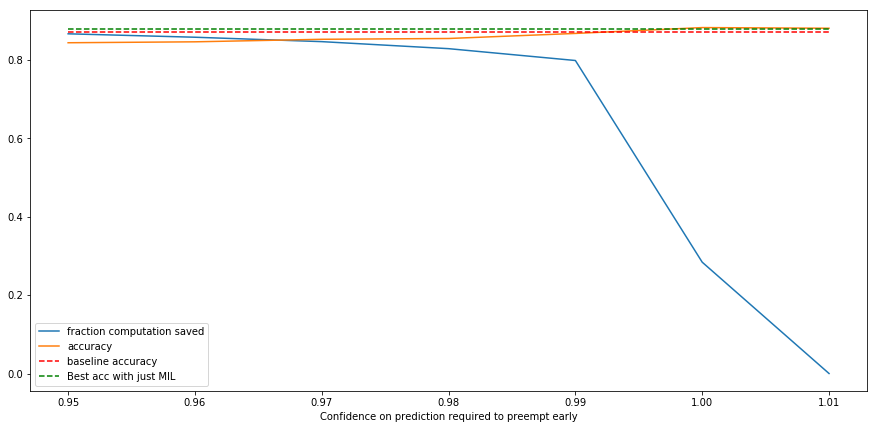

In [8]:
baselineAcc = 0.870437
milBestAcc = 0.877564
fig = plt.figure(figsize=(15, 7))
plt.plot(minProbList, savingsList, label='fraction computation saved')
plt.plot(minProbList, accList, label='accuracy')
plt.plot(minProbList, [baselineAcc] * len(accList), 'r--', label='baseline accuracy')
plt.plot(minProbList, [milBestAcc] * len(accList), 'g--', label='Best acc with just MIL')
plt.xlabel('Confidence on prediction required to preempt early')
plt.legend()
plt.savefig('joint_.png')
plt.show()